Qiskit Density Matrix

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, Kraus
from qiskit_aer import AerSimulator
import numpy as np

# T1 = 50e3       #microseconds
# T2 = 70e3       #microseconds
# duration_ns = 100
# duration_us = duration_ns * 1e-3

# Compute error probabilities
# p_amp = 1 - np.exp(-duration_us / T1)
# p_phase = 1 - np.exp(-duratiSon_us / T2)

T1 = 10 ** -5
n_qubits = 1
exact_params = []
np_taus = np.linspace(10**-6, 10**-5, num=10)
taus = [round(float(tau), 16) for tau in np_taus]
print(np_taus)
T2 = np.arange(T1/10, 2*T1, T1/10)
for tau in taus:  
    exact_rho = []
    for T in T2:
        lam = 1/T - 1/(2*T1)
        p_amp = 1 - np.exp(-tau/T1)
        p_phase = 1 - np.exp(-2*lam*tau)

        #Kraus

        #Amplitude damping (T1)
        K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])
        K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])
        amp_damping = Kraus([K1_amp, K2_amp])

        #Phase damping (T2)
        K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
        K2_phase = np.array([[np.sqrt(p_phase), 0], [0, -np.sqrt(p_phase)]])
        phase_damping = Kraus([K1_phase, K2_phase])

        #Circuit

        qc = QuantumCircuit(n_qubits)

        #GHZ
        qc.h(0)
        # qc.cx(0, 1)

        #Add decoherence
        for qubit in range(n_qubits):
            qc.append(amp_damping.to_instruction(), [qubit])
            qc.append(phase_damping.to_instruction(), [qubit])

        qc.save_density_matrix()

        sim = AerSimulator(method='density_matrix')

        result = sim.run(qc).result()

        rho = np.array(result.data(0)['density_matrix'])
        # print("Final density matrix with manual gamma lambda noise:\n", DensityMatrix(rho))
        exact_rho.append(rho)

    exact_params.append(exact_rho)
print(T2)

[1.e-06 2.e-06 3.e-06 4.e-06 5.e-06 6.e-06 7.e-06 8.e-06 9.e-06 1.e-05]
[1.0e-06 2.0e-06 3.0e-06 4.0e-06 5.0e-06 6.0e-06 7.0e-06 8.0e-06 9.0e-06
 1.0e-05 1.1e-05 1.2e-05 1.3e-05 1.4e-05 1.5e-05 1.6e-05 1.7e-05 1.8e-05
 1.9e-05]


Stim + Pauli Twirling

In [3]:
import stim
import numpy as np

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
pauli_map = {'I': I, 'X': X, 'Y': Y, 'Z': Z}

def kronecker_all(pauli_string):
    """Kronecker product over all characters in pauli_string."""
    result = np.array([[1]], dtype=complex)
    for p in pauli_string:
        result = np.kron(result, pauli_map[p])
    return result

def tableau_to_density_matrix(t: stim.Tableau) -> np.ndarray:
    """Convert a stim.Tableau to a density matrix using canonical stabilizers."""
    s = stim.TableauSimulator()
    s.set_inverse_tableau(t)
    stabilizers = s.canonical_stabilizers()
    
    n = n_qubits
    dim = 1 << n
    rho = np.eye(dim, dtype=complex)
    for stab in stabilizers:
        stab = str(stab)
        sign = -1 if stab[0] == '-' else 1
        pauli_string = stab[1:]  # e.g., "-XZ" -> "XZ"
        S = kronecker_all(pauli_string)
        S *= sign

        proj = 0.5 * (np.eye(dim, dtype=complex) + S)
        rho = rho @ proj

    return rho

def apply_amp_damp_noise(sim: stim.TableauSimulator, qubit: int, p: float):
    """Apply random single-qubit depolarizing noise to a specific qubit."""
    rand = np.random.rand()
    if  rand < p/4:
        pauli = 'X'

        # Build full Pauli string over all qubits
        full_pauli = ['I'] * sim.num_qubits
        full_pauli[qubit] = pauli
        pauli_str = ''.join(full_pauli)

        sim.do(stim.PauliString(pauli_str))
    elif rand < p/2:
        pauli = 'Y'

        # Build full Pauli string over all qubits
        full_pauli = ['I'] * sim.num_qubits
        full_pauli[qubit] = pauli
        pauli_str = ''.join(full_pauli)

        sim.do(stim.PauliString(pauli_str))
    elif rand < 3*p/4:
        pauli = 'Z'

        # Build full Pauli string over all qubits
        full_pauli = ['I'] * sim.num_qubits
        full_pauli[qubit] = pauli
        pauli_str = ''.join(full_pauli)

        sim.do(stim.PauliString(pauli_str))

def apply_phase_damp_noise(sim: stim.TableauSimulator, qubit: int, p: float):
    """Apply random single-qubit depolarizing noise to a specific qubit."""

    if np.random.rand() < p/2:
        pauli = 'Z'

        # Build full Pauli string over all qubits
        full_pauli = ['I'] * sim.num_qubits
        full_pauli[qubit] = pauli
        pauli_str = ''.join(full_pauli)

        sim.do(stim.PauliString(pauli_str))


def generate_error_tableau(p_amp: float, p_phase: float) -> stim.Tableau:
    """Prepare Bell state, apply depolarizing noise, and return the stabilizer tableau."""
    sim = stim.TableauSimulator()

    # Prepare Bell state: (|00⟩ + |11⟩)/√2
    sim.h(0)
    # sim.cx(0, 1)

    for q in range(n_qubits):
        # Apply single-qubit depolarizing noise
        apply_amp_damp_noise(sim, q, p_amp)
        apply_phase_damp_noise(sim, q, p_phase)
    return sim.current_inverse_tableau()


# Parameters
num_shots = 1000   # number of random shots

# Generate tableaus and density matrices

stim_params = []
for tau in taus:  
    twirled = []
    for T in T2:
        stim_dms = []
        lam = 1/T - 1/(2*T1)
        p_amp = 1 - np.exp(-tau/T1)
        p_phase = 1 - np.exp(-2*lam*tau)
        for shot in range(num_shots):
            tableau = generate_error_tableau(p_amp, p_phase)
            rho = tableau_to_density_matrix(tableau)
            stim_dms.append(rho)
            # print(f"\n--- Shot {i+1} Density Matrix ---")
            # print(np.round(rho, 3))
        avg_stim = sum(stim_dms)/ num_shots
        twirled.append(avg_stim)
    stim_params.append(twirled)



STAB Sim Decomposition Script

In [4]:
import subprocess
import numpy as np

stab_params = []

for tau in taus:
    # Compile the C++ program
    compile_result = subprocess.run(
        ["g++", "damping_channel.cpp", "-o", "damping_channel"],
        capture_output=True, text=True
    )
    if compile_result.returncode != 0:
        print("Compilation failed:")
        print(compile_result.stderr)
    else:
        lines = []
        with subprocess.Popen(
            ["./damping_channel", str(tau), str(T1)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            bufsize=1 
        ) as proc:
            for line in proc.stdout:
                print(line, end="")  
                lines.append(line.strip())

            # Wait for process to finish
            proc.wait()

            if proc.returncode != 0:
                error_output = proc.stderr.read()
                print("Runtime Error:")
                print(error_output)


    density_matrices = []
    i = 0
    while i < len(lines):
        if lines[i].startswith("T2="):
            T = float(lines[i].split("=")[1])
            i += 1
            data = list(map(float, lines[i].strip().split()))
            complex_vals = [complex(data[j], data[j+1]) for j in range(0, len(data), 2)]
            dim = int(len(complex_vals)**0.5)
            rho = np.array(complex_vals).reshape((dim, dim))
            density_matrices.append(rho)
        i += 1
    stab_params.append(density_matrices)

0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.0951626
0.119078 0.785759 0.

**STAB Sim Exact Decomposition**

19


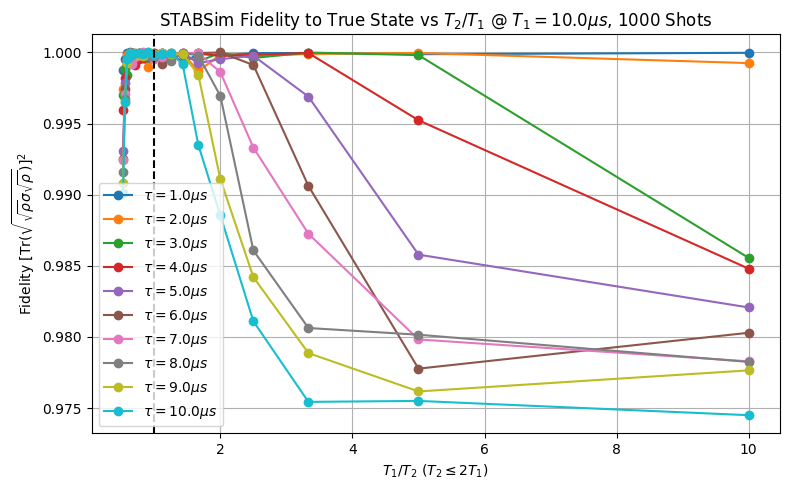

In [5]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
print(len(T2))
for i in range(len(taus)):
    fidelities = []
    for j in range(len(T2)):
        
        rho = np.real(exact_params[i][j])
        sigma = np.real(stab_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2) , fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.plot()

plt.axvline(x=1, color='black', linestyle='--')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'STABSim Fidelity to True State vs $T_2/T_1$ @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#check diamond norm

**Stim Pauli Twirling Decomposition**

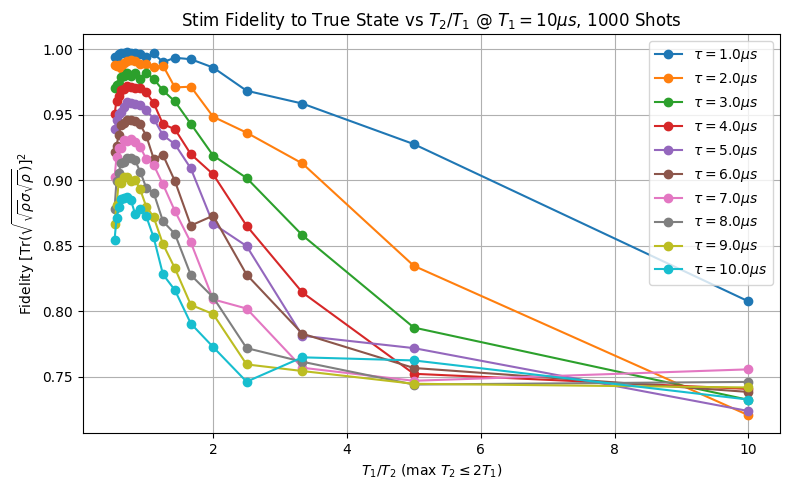

In [6]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# def clean_density_matrix(rho, eps=1e-12):
#     """Stabilize a nearly-valid density matrix."""
#     rho = (rho + rho.conj().T) / 2  # Enforce Hermitian
#     eigvals, eigvecs = np.linalg.eigh(rho)
#     eigvals = np.clip(eigvals, eps, None)  # Avoid zero or negative eigenvalues
#     rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
#     return rho / np.trace(rho)

# def stable_sqrtm(mat):
#     """Stable square root of a matrix, forcing Hermitian output."""
#     sqrt = sqrtm(mat)
#     if np.any(np.isnan(sqrt)) or np.any(np.isinf(sqrt)):
#         raise ValueError("sqrtm failed: produced NaNs or infs.")
#     return (sqrt + sqrt.conj().T) / 2  # Hermitian

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return fid

# Assuming true_dms and approx_dms are already defined
# print(density_matrices)
# print(exact_rho)

tau_fidelities = []

# f = fidelity(exact_rho[.001], density_matrices[.001])
# print(f)
for i in range(len(taus)):
    fidelities = []
    for j, T in enumerate(T2):
        rho = np.real(exact_params[i][j])
        sigma = np.real(stim_params[i][j])
        f = fidelity(rho, sigma)
        fidelities.append(f)
    tau_fidelities.append(fidelities)

# print(exact_rho)
# print(density_matrices)
# print(tau_fidelities[0])

# Plot
plt.figure(figsize=(8, 5))

for i, fidelities in enumerate(tau_fidelities):
    plt.plot(T1/np.array(T2), fidelities, marker='o', label=fr'$\tau = {round(10**6*taus[i], 2)}\mu s$')

plt.xlabel(r'$T_1/T_2$ (max $T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(r'Stim Fidelity to True State vs $T_2/T_1$ @ $T_1 = 10\mu s$, 1000 Shots')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

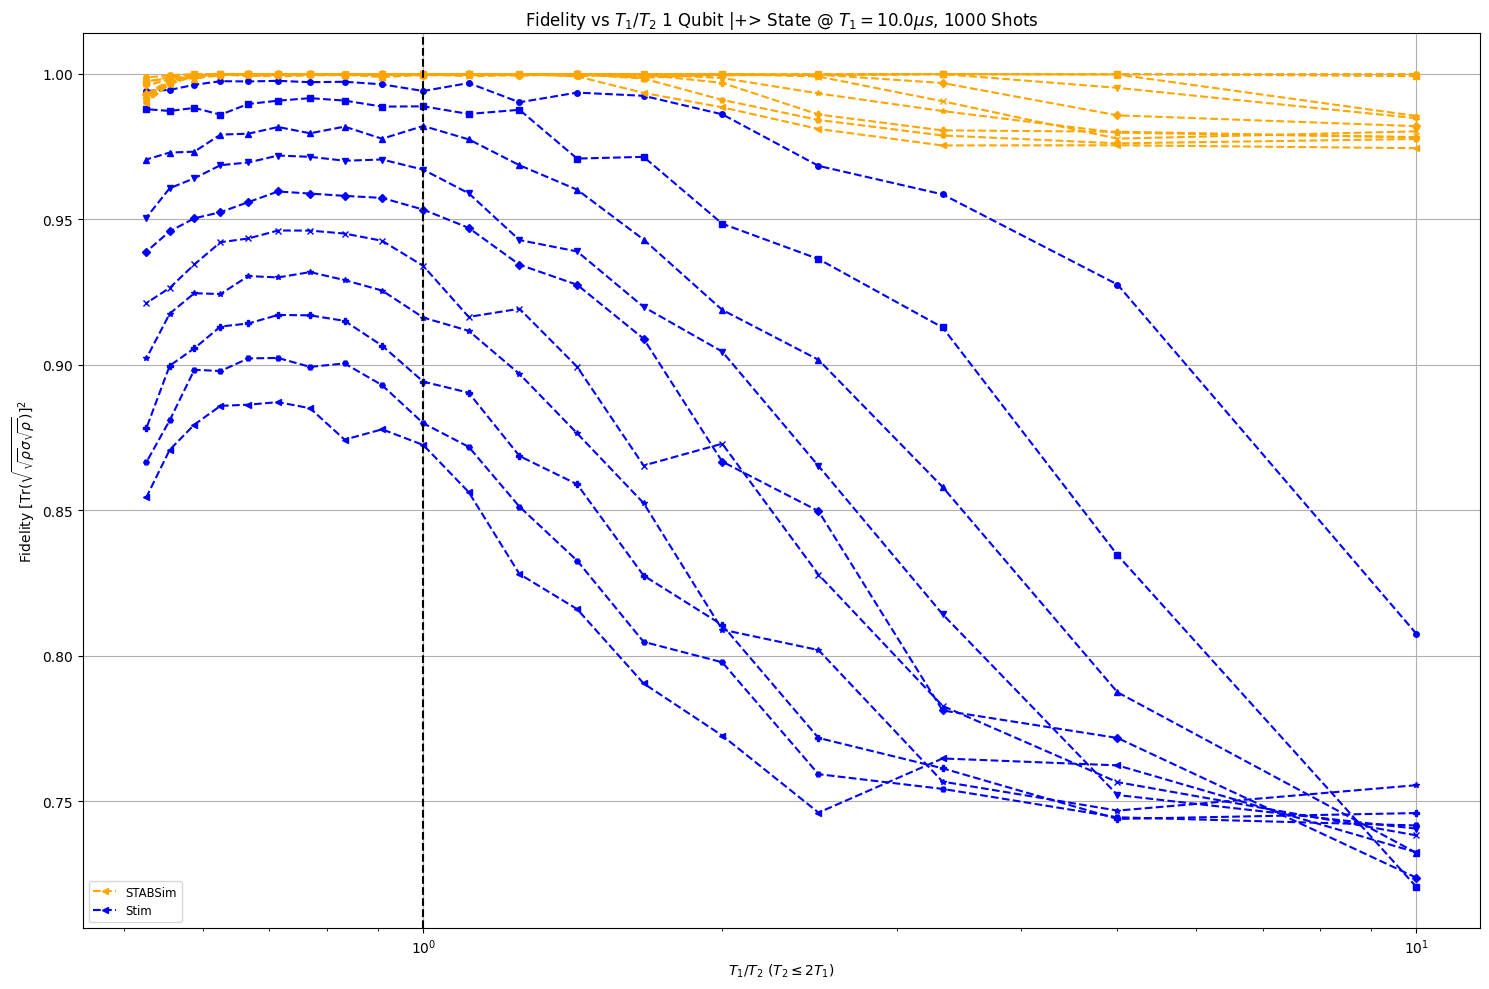

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm

def fidelity(rho, sigma):
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    fid = (np.trace(inner)) ** 2
    return np.real(fid)

# Example marker cycle (one per tau)
markers = ['o', 's', '^', 'v', 'D', 'x', '*', 'P', 'H', '<', '>']
# Truncate or repeat if necessary
markers = (markers * ((len(taus) // len(markers)) + 1))[:len(taus)]

colors = ['blue', 'orange']  # Group 1 (exact), Group 2 (stab)

plt.figure(figsize=(15, 10))

for i, tau in enumerate(taus):
    # Group 1: exact_params
    fidelities_stab = [
        fidelity(np.real(exact_params[i][j]), np.real(stab_params[i][j]))
        for j in range(len(T2))
    ]
    plt.plot(
        T1 / np.array(T2),
        fidelities_stab,
        color=colors[1],
        marker=markers[i],
        markersize=4,  # Smaller marker
        linewidth=1.5,
        linestyle='--',
        label=fr'STABSim'
    )

    # Group 2: stab_params to another reference (if you have a second group)
    fidelities_stim = [
        fidelity(np.real(exact_params[i][j]), np.real(stim_params[i][j]))
        for j in range(len(T2))
    ]
    plt.plot(
        T1 / np.array(T2),
        fidelities_stim,
        color=colors[0],
        marker=markers[i],
        markersize=4,
        linewidth=1.5,
        linestyle='--',
        label='Stim'
    )

plt.axvline(x=1, color='black', linestyle='--')

plt.xlabel(r'$T_1/T_2$ ($T_2 \leq 2T_1$)')
plt.ylabel(r'Fidelity $[\mathrm{Tr}(\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}})]^2$')
plt.title(rf'Fidelity vs $T_1/T_2$ 1 Qubit |+> State @ $T_1 ={10**6*T1}\mu s$, 1000 Shots')

# Only label the two groups once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize='small')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()
